<a href="https://colab.research.google.com/github/lucia1299/BERTolde/blob/main/finetuning_gilberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets tokenizers seqeval -q

In [ ]:
import datasets
import numpy as np
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from datasets import Dataset, ClassLabel, Features, Sequence, Value, DatasetDict

def creationdictionary(data, posdict, nerdict, pos_tags_list, ner_tags_list):
    container_list = []

    while data:
        container_dict = {}
        pos_list = []
        ner_list = []
        words_list = []

        index_of_empty_list = data.index([]) if [] in data else len(data)
        tokenized_data1 = data[0: index_of_empty_list]
        for n in tokenized_data1:
            if 'id' not in container_dict:
                container_dict['id'] = 0
            else:
                container_dict['id'] += 1
            if n[1] in posdict:
                pos_list.append(posdict[n[1]])
            if n[3] in nerdict:
                ner_list.append(nerdict[n[3]])
            words_list.append(n[0])

        container_dict['pos'] = pos_list
        container_dict['ner_tags'] = ner_list
        container_dict['tokens'] = words_list
        container_dict['issueid'] = tokenized_data1[0][2]
        container_dict['id'] = str(container_dict['id'])

        container_list.append(container_dict)

        data = data[index_of_empty_list + 1:]

    container_dict = {key: [d[key] for d in container_list] for key in container_list[0]}

    ds = Dataset.from_dict(container_dict, features=Features({
        'pos': Sequence(ClassLabel(names=pos_tags_list)),
        'ner_tags': Sequence(ClassLabel(names=ner_tags_list)),
        'tokens': Sequence(Value(dtype='string')),
        'issueid': Value(dtype='string'),
        'id': Value(dtype='string')
        }))

    return ds

def posconversion(data):
    posdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 1:
            pos_tag = i[1]
            set1.add(pos_tag)
    pos_tags_list = list(set1)
    v = 0
    for i in set1:
        posdict[i] = v
        v +=1
    return posdict, pos_tags_list

def nerconversion(data):
    nerdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 4:
            ner_tag = i[3]
            set1.add(ner_tag)
    ner_tags_list = list(set1)
    v = 0
    for i in set1:
        nerdict[i] = v
        v +=1
    return nerdict, ner_tags_list

file_path_training = '/content/I-CAB-evalita09-NER-training.iob2'
file_path_test = '/content/I-CAB-evalita09-NER-test.iob2'

def read_iob_data(file_path):
     with open(file_path, 'r', encoding='ISO-8859-1') as file:
         iob_data = file.readlines()

     data = [line.strip().split() for line in iob_data]
     return data

data_training = read_iob_data(file_path_training)
posdict, pos_tags_list = posconversion(data_training)
nerdict, ner_tags_list = nerconversion(data_training)
result_training = creationdictionary(data_training, posdict, nerdict, pos_tags_list, ner_tags_list)

data_test = read_iob_data(file_path_test)
posdict, pos_tags_list = posconversion(data_test)
nerdict, ner_tags_list = nerconversion(data_test)
result_test = creationdictionary(data_test, posdict, nerdict, pos_tags_list, ner_tags_list)

main_dataset = DatasetDict({"train": result_training, "test": result_test})
print(main_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 11227
    })
    test: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 4136
    })
})


In [ ]:
main_dataset.shape

{'train': (11227, 5), 'test': (4136, 5)}

In [ ]:
main_dataset['train'][1]

{'id': '6',
 'pos': [22, 13, 22, 14, 25, 5, 6],
 'ner_tags': [3, 3, 3, 3, 3, 3, 0],
 'tokens': ['Latte', 'al', 'seno', ',', 'sos', 'di', 'Pedrotti'],
 'issueid': 'adige20041007_id413942'}

In [ ]:
main_dataset['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['B-PER', 'B-ORG', 'I-LOC', 'O', 'B-GPE', 'I-ORG', 'I-GPE', 'B-LOC', 'I-PER'], id=None), length=-1, id=None)

In [ ]:
!pip install sentencepiece

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('idb-ita/gilberto-uncased-from-camembert', do_lower_case=True)

#do_lower_case needs to be used because this is how the instatiation of CamembertTokenizerFast works

In [ ]:
example_text = main_dataset['train'][1]

tokenized_input = tokenizer(example_text['tokens'], is_split_into_words=True)

tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])

word_ids = tokenized_input.word_ids()

#ValueError: word_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).
#this is why we need to use TokenizersFast also for Roberta

word_ids


[None, 0, 0, 0, 1, 2, 3, 4, 5, 6, 6, 6, 6, None]

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
tokens

#<s> and </s> are mapped to NONE because the they are "special tokens"

['<s>',
 '▁',
 '<unk>',
 'atte',
 '▁al',
 '▁seno',
 '▁,',
 '▁sos',
 '▁di',
 '▁',
 '<unk>',
 'ed',
 'rotti',
 '</s>']

In [ ]:
len(example_text['ner_tags']), len(tokenized_input['input_ids'])

(7, 14)

In [ ]:
def tokenize_and_align_labels(example, label_all_tokens =True):
    tokenized_input = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)

    labels = []

    for i, label in enumerate(example['ner_tags']):
        word_ids = tokenized_input.word_ids(batch_index=i)
        #it returns a list indicating the word corresponding to each token
        previous_word_idx = None

        label_ids =[]

        for word_idx in word_ids:
            if word_idx is None:
                #special tokens
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                #regular case
                label_ids.append(label[word_idx])
            else:
                #subword case
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_input['labels'] = labels
    return tokenized_input

In [ ]:
q = tokenize_and_align_labels(main_dataset['train'][4:5])
print(q)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[5, 31924, 3, 222, 315, 25810, 57, 31924, 3, 6974, 2907, 31924, 3, 31944, 31924, 3, 18580, 24, 81, 18130, 21, 25538, 33, 31924, 3, 346, 1962, 777, 21, 8405, 48, 1532, 6478, 777, 21, 18264, 13, 317, 108, 425, 88, 10428, 56, 1648, 206, 1876, 6810, 1009, 6]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, -100]]}


In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q['input_ids'][0]), (q['labels'][0])):
    print(f"{token:_<40} {label}")

<s>_____________________________________ -100
▁_______________________________________ 3
<unk>___________________________________ 3
ggi_____________________________________ 3
▁alle___________________________________ 3
▁17.30__________________________________ 3
▁al_____________________________________ 3
▁_______________________________________ 3
<unk>___________________________________ 3
entro___________________________________ 3
▁culturale______________________________ 3
▁_______________________________________ 3
<unk>___________________________________ 3
._______________________________________ 3
▁_______________________________________ 3
<unk>___________________________________ 3
hia_____________________________________ 3
ra______________________________________ 3
▁si_____________________________________ 3
▁parlerà________________________________ 3
▁di_____________________________________ 3
▁allattamento___________________________ 3
▁in_____________________________________ 3
▁_______

In [ ]:
tokenized_dataset = main_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/11227 [00:00<?, ? examples/s]

Map:   0%|          | 0/4136 [00:00<?, ? examples/s]

In [ ]:
num_labels = main_dataset['train'].features['ner_tags'].feature.num_classes
num_labels

9

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("idb-ita/gilberto-uncased-from-camembert", num_labels = num_labels)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at idb-ita/gilberto-uncased-from-camembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install accelerate -U

In [ ]:
pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(optimizer, 1400, 17400)
#scheduler (optimizer, num_steps, num_warmup_steps, num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


*   Number of Training Steps: A training step is one gradient update, where in one step, a batch of examples is processed. The number of training steps indicates how many times the weights of the network are updated. It is often used in the context of specifying the duration of training, and the model is trained for a certain number of steps.
*   Number of Epochs: An epoch is a complete pass through the entire training dataset. It consists of one or more batches. The number of epochs defines how many times the learning algorithm will work through the entire training dataset. It is a hyperparameter that is traditionally set to a large number, allowing the learning algorithm to run until the error from the model has been sufficiently minimized.

In [ ]:
#define training arguments parameters
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "test-ner",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
#objects that will form a batch by using a list of dataset elements as input - they are the same type of the elements of the trian dataset

In [ ]:
metric = datasets.load_metric('seqeval')
#utureWarning: load_metric is deprecated and will be removed in the next major version of datasets.
# Use 'evaluate.load' instead, from the new library 🤗
example = main_dataset['train'][0]

<ipython-input-23-1a25687c91d7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('seqeval')


In [ ]:
label_list = main_dataset['train'].features['ner_tags'].feature.names
label_list

['B-PER', 'B-ORG', 'I-LOC', 'O', 'B-GPE', 'I-ORG', 'I-GPE', 'B-LOC', 'I-PER']

In [ ]:
example = main_dataset['train'][1]

In [ ]:
#calculate the metric on a single example (the first of the train dataset)
labels = [label_list[i] for i in example['ner_tags']]
labels

['O', 'O', 'O', 'O', 'O', 'O', 'B-PER']

In [ ]:
#check metric.compute works
metric.compute(predictions=[labels], references=[labels])
#the score of this is very high because I pass the same list to both my predictions and references

{'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
def compute_metrics(eval_preds):
    pred_logits, labels = eval_preds

    # pred_logits are obtained by passing numpy.argmax
    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    # define the variable prediction here
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]
    # define the variable true_labels here
    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
    ]
    results = metric.compute(predictions=predictions, references=true_labels)

    global stored_predictions, stored_labels
    stored_predictions.extend(predictions)
    stored_labels.extend(true_labels)

    return {
   "precision": results["overall_precision"],
   "recall": results["overall_recall"],
   "f1": results["overall_f1"],
    "accuracy": results["overall_accuracy"],
  }

In [ ]:
stored_predictions = []
stored_labels = []

In [ ]:
trainer = Trainer (
    model,
    args,
    optimizers=(optimizer, scheduler),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

model.save_pretrained('ner_model')

tokenizer.save_pretrained('tokenizer')

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.200500,0.234282,0.818707,0.807749,0.813191,0.948174
2,0.132000,0.205878,0.846670,0.824271,0.835320,0.953361
3,0.072000,0.242150,0.840957,0.856478,0.848647,0.957102
4,0.035800,0.278065,0.849243,0.850308,0.849775,0.958337
5,0.032500,0.271927,0.852142,0.852766,0.852454,0.958549
6,0.011300,0.289389,0.847925,0.864373,0.856070,0.959541


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/sentencepiece.bpe.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
from conlleval import evaluate

true_flat = [item for sublist in stored_labels for item in sublist]
pred_flat = [item for sublist in stored_predictions for item in sublist]

# print out the table as above
evaluate(true_flat, pred_flat, verbose=True)

# calculate overall metrics
prec, rec, f1 = evaluate(true_flat, pred_flat, verbose=False)

processed 737928 tokens with 114756 phrases; found: 114756 phrases; correct: 96700.
accuracy:  85.34%; (non-O)
accuracy:  95.58%; precision:  84.27%; recall:  84.27%; FB1:  84.27
              GPE: precision:  81.42%; recall:  81.70%; FB1:  81.56  25305
              LOC: precision:  50.64%; recall:  31.65%; FB1:  38.96  1785
              ORG: precision:  75.96%; recall:  77.84%; FB1:  76.89  29084
              PER: precision:  90.65%; recall:  91.08%; FB1:  90.86  58582


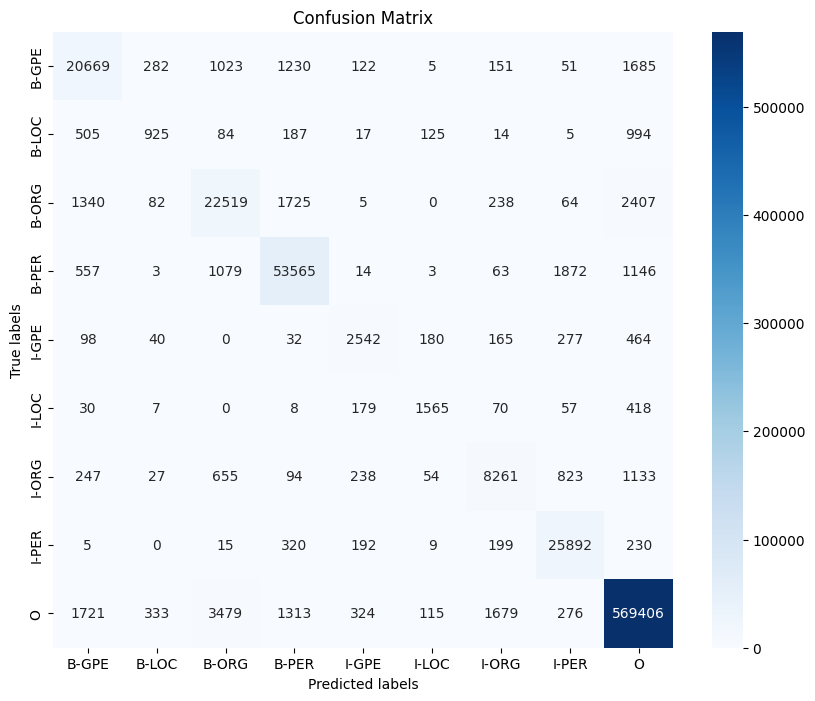

In [ ]:
conf_matrix = confusion_matrix(np.concatenate(stored_labels), np.concatenate(stored_predictions))
labels = sorted(list(set(np.concatenate(stored_labels))))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
id2label= {
    str(i):label for i, label in enumerate(label_list)
}

label2id = {
    label:str(i) for i, label in enumerate(label_list)
}

In [ ]:
import json

config = json.load(open('ner_model/config.json'))

In [ ]:
config['id2label'] = id2label
config['label2id'] = label2id

json.dump(config, open('ner_model/config.json', 'w'))

model_fine_tuned = AutoModelForTokenClassification.from_pretrained("ner_model")

test on evaluation text

In [ ]:
from transformers import pipeline

In [ ]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

example = "Giorgia e Lucia hanno trovato un fiore in Trentino e l'hanno portato all'ONU ma a loro non è piaciuto quindi Pedrotti le ha sgridate"

ner_results = nlp(example)

print(ner_results)

[{'entity': 'B-PER', 'score': 0.99929345, 'index': 1, 'word': '▁', 'start': 0, 'end': 1}, {'entity': 'B-PER', 'score': 0.99928015, 'index': 2, 'word': 'G', 'start': 0, 'end': 1}, {'entity': 'B-PER', 'score': 0.99937195, 'index': 3, 'word': 'i', 'start': 1, 'end': 2}, {'entity': 'B-PER', 'score': 0.99930847, 'index': 4, 'word': 'or', 'start': 2, 'end': 4}, {'entity': 'B-PER', 'score': 0.9994473, 'index': 5, 'word': 'gia', 'start': 4, 'end': 7}, {'entity': 'B-PER', 'score': 0.99955124, 'index': 7, 'word': '▁', 'start': 9, 'end': 10}, {'entity': 'B-PER', 'score': 0.9995622, 'index': 8, 'word': 'L', 'start': 10, 'end': 11}, {'entity': 'B-PER', 'score': 0.9995221, 'index': 9, 'word': 'u', 'start': 11, 'end': 12}, {'entity': 'B-PER', 'score': 0.9995509, 'index': 10, 'word': 'cia', 'start': 12, 'end': 15}, {'entity': 'B-GPE', 'score': 0.998895, 'index': 16, 'word': '▁', 'start': 41, 'end': 42}, {'entity': 'B-GPE', 'score': 0.9989047, 'index': 17, 'word': 'T', 'start': 42, 'end': 43}, {'entity